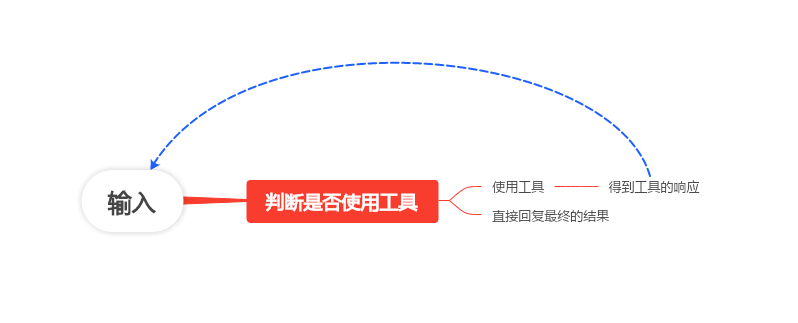

In [1]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_key = "empty",
    openai_api_base="http://127.0.0.1:1234/v1",
    temperature=0.3
)

In [2]:
promptTemplate = """尽可能帮助用户回答任何的问题。

您可以使用以下工具来帮忙解决问题，如果已经知道了答案，也可以直接回答。

{tools}

回复我时，请以下面2种格式之一进行回复：

格式1：如果你希望使用工具，请使用此JSON格式回复内容：
{{
    "reason": string, //叙述使用工具的原因
    "action": string, //要使用的工具。必须是 {tool_names} 之一
    "action_input": string //工具的输入
}}

格式2：如果你认为你已经有答案或者已经通过使用工具找到了答案，想直接对用户的输入作出回复，请使用此JSON格式回复：
{{
    "action":"Final Answer",
    "answer": string //最终回复问题的答案放在这里
}}

下面是用户的输入，请记住只回复上面的2种格式的其中1种，必须以json格式回复，不要回复其他内容。
用户的输入：{input}
"""

In [3]:
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system","你是非常强大的助手，你可以使用各种工具来完成人类交给的问题和任务"),
    ("user",promptTemplate),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])





In [8]:
#导入langchain
from langchain.agents import tool
import requests

@tool
def searxng_search(query):
    """输入搜索内容，使用SearxNG进行搜索"""
    Searxng_url = "http://127.0.0.1:6688"
    # 配置搜索参数
    #q=刘亦菲&category_general=1&language=auto&time_range=&safesearch=0&theme=simple&format=json#/
    params = {
        "q":query,
        "format":"json",
        "category_general":"",
        "language":"auto",
        "time_range":"",
        # "safesearch":"2",
        # "engines":"bing"
        # "category_videos":""
    }
    #发送请求
    response = requests.get(Searxng_url,params=params)
    # print(response)
    if response.status_code == 200:
        res = response.json()
        resList = []
        for item in res["results"]:
            resList.append({
                "title":item["title"],
                "content":item["content"],
                "url":item["url"]
            })
        # print(res)
        return resList[:3]
    else:
        return response.raise_for_status()



searxng_search.invoke("刘亦菲 最近 活动")

[{'title': '2023年刘亦菲宝格丽的三次活动',
  'content': '2023年12月24日 — 刘亦菲最近造型团队摸到灵感了，她的五官和身材特点特别适合油画风。自从前段时期柳宗源拍了这个系列之后的活动GQ，还有芭莎封面视频，宝格丽晚宴和 ...',
  'url': 'https://m.163.com/dy/article/IMOEG9KF05562JCP.html'},
 {'title': '刘亦菲最近活动',
  'content': '12月21日，刘亦菲出席澳门国际电影节活动造型曝光，照片中，刘亦菲身穿一袭天蓝色抹胸连衣裙，外搭同色系披风，性感又迷人。',
  'url': 'https://www.toutiao.com/keyword/214095189'},
 {'title': '刘亦菲百万穿搭亮相宝格丽活动，生图暴露麒麟臂',
  'content': '2023年11月16日 — 最近，女星刘亦菲现身奢牌活动，早在开场之前，大家就对刘亦菲的现场状态充满期待。刘亦菲团队方面也早早放出美图，然而，在看过刘亦菲的现场照之后，却 ...',
  'url': 'https://www.163.com/dy/article/IJMSVED405179RJN.html'}]

In [9]:
@tool
def get_weather(location):
    """根据输入的城市名称获取天气数据"""
    api_key = "SKcA5FGgmLvN7faJi"
    url = f"https://api.seniverse.com/v3/weather/now.json?key={api_key}&location={location}&language=zh-Hans&unit=c"
    response = requests.get(url)
    print(location)
    if response.status_code == 200:
        data = response.json()
        #print(data)
        weather = {
            'description':data['results'][0]["now"]["text"],
            'temperature':data['results'][0]["now"]["temperature"]
        }
        return weather
    else:
        raise Exception(f"失败接收天气信息：{response.status_code}")

In [10]:
# from langchain.agents import Tool
# from langchain_experimental.utilities import PythonREPL

# python_repl = PythonREPL()
# repl_tool = Tool(
#     name="python_repl",
#     description="Python代码解释器，输入应该为有效的python命令。如果想要查看某个值的输出，应该使用print(...)打印出来",
#     func=python_repl.run
# )

In [11]:
tools = [get_weather,searxng_search]

In [12]:
from langchain.tools.render import render_text_description

prompt = prompt.partial(
    tools = render_text_description(tools),
    tool_names = ", ".join([t.name for t in tools])
    
)
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'tools': 'get_weather: get_weather(location) - 根据输入的城市名称获取天气数据\nsearxng_search: searxng_search(query) - 输入搜索内容，使用SearxNG进行搜索', 'tool_names': 'get_weather, searxng_search'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='你是非常强大的助手，你可以使用各种工具来完成人类交给的问题和任务')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input', 'tool_names', 'tools'], template='尽可能帮助用户回答任何的问题。\n\n您可以使用以下工具来帮忙解决问题，如果已经知道了答案，也可以直接回答。\n\n{tools}\n\n回复我时，请以下面2种格式之一进行回复：\n\n格式1：如果你希望使用工具，请使用此JSON格式回复内容：\n{{\n    "reason": string, //叙述使用工具的原因\n    "action": string

In [13]:
from langchain_core.output_parsers.json import parse_json_markdown

In [14]:
def jsonParser(message):
    return parse_json_markdown(message.content)
chain = prompt | llm | jsonParser

In [15]:
result = chain.invoke({
    "input":"刘亦菲最近有什么活动？",
    "agent_scratchpad":[]
})
result

{'action': 'searxng_search', 'action_input': '刘亦菲 最近 活动'}

In [16]:
def isUseTool(obj):
    if obj["action"] == "Final Answer":
        return END
    else:
        for tool  in tools:
            if obj["action"] == tool.name:
                print(obj["action_input"])
                return tool.invoke(obj["action_input"])
        print("找不到对应的工具名称：",obj["action"])

isUseTool(result)
    

刘亦菲 最近 活动


[{'title': '2023年刘亦菲宝格丽的三次活动',
  'content': '2023年12月24日 — 刘亦菲最近造型团队摸到灵感了，她的五官和身材特点特别适合油画风。自从前段时期柳宗源拍了这个系列之后的活动GQ，还有芭莎封面视频，宝格丽晚宴和 ...',
  'url': 'https://m.163.com/dy/article/IMOEG9KF05562JCP.html'},
 {'title': '刘亦菲最近活动',
  'content': '12月21日，刘亦菲出席澳门国际电影节活动造型曝光，照片中，刘亦菲身穿一袭天蓝色抹胸连衣裙，外搭同色系披风，性感又迷人。',
  'url': 'https://www.toutiao.com/keyword/214095189'},
 {'title': '刘亦菲百万穿搭亮相宝格丽活动，生图暴露麒麟臂',
  'content': '2023年11月16日 — 最近，女星刘亦菲现身奢牌活动，早在开场之前，大家就对刘亦菲的现场状态充满期待。刘亦菲团队方面也早早放出美图，然而，在看过刘亦菲的现场照之后，却 ...',
  'url': 'https://www.163.com/dy/article/IJMSVED405179RJN.html'}]

```python
[
    ("system","你是非常强大的助手，你可以使用各种工具来完成人类交给的问题和任务"),
    ("user",promptTemplate),
    ("assiatant","""{'reason': '用户询问了关于刘亦菲最近的活动信息，我需要搜索来获取答案','action': 'searxng_search','action_input': '刘亦菲 最近 活动'}"""
    ("user","""工具响应：
------
[{'title': '刘亦菲（华语影视女演员、歌手）_百度百科',
  'content': '刘亦菲，1987年8月25日出生于湖北省武汉市，华语影视女演员、歌手，毕业于北京电影学院2002级表演系本科。 2002年，因出演民国剧《金粉世家》中白秀珠一角踏入演艺圈。 2003年，凭借武侠剧《天龙八部》中王语嫣一角提名第1届电视剧风云盛典古装剧最佳女演员。 2004年，凭借仙侠剧《仙剑奇侠传》中的赵灵儿一角获得高人气与关 …',
  'url': 'https://baike.baidu.com/item/%E5%88%98%E4%BA%A6%E8%8F%B2/136156'},
 {'title': '刘亦菲 - 搜狗百科',
  'content': '刘亦菲（Crystal Liu，1987年8月25日-），出生于湖北省武汉市，毕业于北京电影学院，美籍华裔女演员、歌手。 2002年，因出演电视剧《金粉世家》中白秀珠一角踏入演艺圈。2003年，因主演武侠剧《天龙八部》王语嫣崭露头角。',
  'url': 'https://baike.sogou.com/v53047.htm?fromTitle=%E5%88%98%E4%BA%A6%E8%8F%B2'},
 {'title': '如何评价刘亦菲? - 知乎',
  'content': '刘亦菲是一个业务能力单薄的敬业演员和一个极其善良坚强的人。. 是一个是非争议不断的话题艺人，路人缘知名度好到逆天的 超级明星 。. 也同时是一个拥有伟大的艺术家梦，却被困在传奇美貌 …',
  'url': 'https://www.zhihu.com/question/31126795/answer/746595656'}]
------

请根据工具的响应判断，是否能够回答问题：

{input}

请根据工具响应的内容，思考接下来回复。回复格式严格按照前面所说的2种JSON回复格式，选择其中1种进行回复。请记住只选择单个选项格式，以JSON格式回复内容，不要回复其他内容

""")
)
]
```

In [22]:
tool_response_prompt = """工具响应：
------
[{{'title': '2023年刘亦菲宝格丽的三次活动',
  'content': '2023年12月24日 — 刘亦菲最近造型团队摸到灵感了，她的五官和身材特点特别适合油画风。自从前段时期柳宗源拍了这个系列之后的活动GQ，还有芭莎封面视频，宝格丽晚宴和 ...',
  'url': 'https://m.163.com/dy/article/IMOEG9KF05562JCP.html'}},
 {{'title': '刘亦菲最近活动',
  'content': '12月21日，刘亦菲出席澳门国际电影节活动造型曝光，照片中，刘亦菲身穿一袭天蓝色抹胸连衣裙，外搭同色系披风，性感又迷人。',
  'url': 'https://www.toutiao.com/keyword/214095189'}},
 {{'title': '刘亦菲百万穿搭亮相宝格丽活动，生图暴露麒麟臂',
  'content': '2023年11月16日 — 最近，女星刘亦菲现身奢牌活动，早在开场之前，大家就对刘亦菲的现场状态充满期待。刘亦菲团队方面也早早放出美图，然而，在看过刘亦菲的现场照之后，却 ...',
  'url': 'https://www.163.com/dy/article/IJMSVED405179RJN.html'}}]
------

请根据工具的响应判断，是否能够回答问题：

{input}

请根据工具响应的内容，思考接下来回复。回复格式严格按照前面所说的2种JSON回复格式，选择其中1种进行回复。请记住只选择单个选项格式，以JSON格式回复内容，不要回复其他内容

"""

In [23]:
from langchain_core.messages import AIMessage,HumanMessage
query = "刘亦菲最近有什么活动？";
agent_scratchpad = [
    AIMessage("{'reason': '用户询问了关于刘亦菲最近的活动信息，我需要搜索来获取答案','action': 'searxng_search','action_input': '刘亦菲 最近 活动'}"),
    HumanMessage(
        content = tool_response_prompt.format(input=query),
    )
]
chain = prompt | llm 
result = chain.invoke({
    "input":"刘亦菲最近有什么活动？",
    "agent_scratchpad":agent_scratchpad
})
result

AIMessage(content='{ \n"action": "Final Answer", \n"answer": "刘亦菲最近的活动包括：\n\n1. 2023年12月24日，她出席了宝格丽的活动，并且造型团队似乎找到了新的灵感，她的五官和身材特点特别适合油画风。这次活动的相关内容可以在GQ杂志和芭莎封面视频中找到。\n\n2. 2023年12月21日，刘亦菲参加了澳门国际电影节，她身穿天蓝色抹胸连衣裙和同色系披风，造型性感迷人。\n\n3. 2023年11月16日，刘亦菲在宝格丽的活动上亮相，她的穿搭价值百万，尽管生图显示了她的麒麟臂，但整体状态依然引人注目。\n\n你可以通过上述提及的链接获取更多详细信息和图片。" \n}', response_metadata={'token_usage': {'completion_tokens': 189, 'prompt_tokens': 189, 'total_tokens': 378}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None})

In [24]:
from langgraph.graph import END,StateGraph,MessageGraph
from typing import TypedDict,List,Annotated
import operator

class GState(TypedDict):
    messages: Annotated[List, operator.add]

In [25]:
def isUseTool(gState):
    print("isUseTool------------")
    print(gState)
    obj = gState["messages"][-1]
    if obj["action"] == "Final Answer":
        return END
    else:
        return "toolNode"


def useTool(gState):
    print("useTool------------")
    print(gState)
    obj = gState["messages"][-1]
    for tool  in tools:
        if obj["action"] == tool.name:
            # print(obj["action_input"])
            return {"messages":[tool.invoke(obj["action_input"])]}
    print("找不到对应的工具名称：",obj["action"])

In [26]:
import json
agentGraph = StateGraph(GState)

def startParse(gState):
    print("startParse--------------")
    print(gState)
    tool_response_prompt = """工具响应：
------
{tools_response}
------

请根据工具的响应判断，是否能够回答问题：

{input}

请根据工具响应的内容，思考接下来回复。回复格式严格按照前面所说的2种JSON回复格式，选择其中1种进行回复。请记住只选择单个选项格式，以JSON格式回复内容，不要回复其他内容

"""
    if len( gState["messages"])>1:
        agent_scratchpad = [
            AIMessage(json.dumps(gState["messages"][-2])),
            HumanMessage(
                content = tool_response_prompt.format(
                    input=gState["messages"][0],
                    tools_response=json.dumps(gState["messages"][-1])
                ),
            )
        ]
    else:
        agent_scratchpad = []
    return {
        "input":gState["messages"][0],
        "agent_scratchpad":agent_scratchpad
    }

def startMsgParse(message):
    message = message.content.replace("'",'"')
    message = parse_json_markdown(message)
     
    return {"messages":[message]}

agentGraph.add_node("startNode", startParse | chain | startMsgParse )

agentGraph.add_node("toolNode", useTool )

agentGraph.add_conditional_edges("startNode",isUseTool)

agentGraph.add_edge("toolNode","startNode")

agentGraph.set_entry_point("startNode")

agent = agentGraph.compile()
# agent


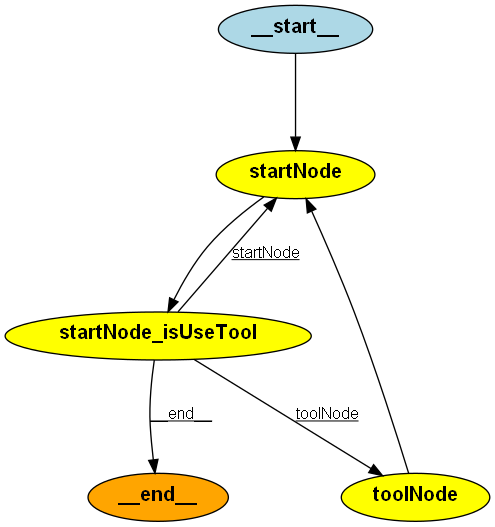

In [27]:
from IPython.display import Image

Image(agent.get_graph().draw_png())

In [29]:
agent.invoke({"messages":["刘亦菲最近有什么活动？"]})

startParse--------------
{'messages': ['刘亦菲最近有什么活动？']}
isUseTool------------
{'messages': ['刘亦菲最近有什么活动？', {'action': 'searxng_search', 'action_input': '刘亦菲 最近 活动'}]}
useTool------------
{'messages': ['刘亦菲最近有什么活动？', {'action': 'searxng_search', 'action_input': '刘亦菲 最近 活动'}]}
startParse--------------
{'messages': ['刘亦菲最近有什么活动？', {'action': 'searxng_search', 'action_input': '刘亦菲 最近 活动'}, [{'title': '2023年刘亦菲宝格丽的三次活动', 'content': '2023年12月24日 — 刘亦菲最近造型团队摸到灵感了，她的五官和身材特点特别适合油画风。自从前段时期柳宗源拍了这个系列之后的活动GQ，还有芭莎封面视频，宝格丽晚宴和 ...', 'url': 'https://m.163.com/dy/article/IMOEG9KF05562JCP.html'}, {'title': '刘亦菲最近活动', 'content': '12月21日，刘亦菲出席澳门国际电影节活动造型曝光，照片中，刘亦菲身穿一袭天蓝色抹胸连衣裙，外搭同色系披风，性感又迷人。', 'url': 'https://www.toutiao.com/keyword/214095189'}, {'title': '刘亦菲百万穿搭亮相宝格丽活动，生图暴露麒麟臂', 'content': '2023年11月16日 — 最近，女星刘亦菲现身奢牌活动，早在开场之前，大家就对刘亦菲的现场状态充满期待。刘亦菲团队方面也早早放出美图，然而，在看过刘亦菲的现场照之后，却 ...', 'url': 'https://www.163.com/dy/article/IJMSVED405179RJN.html'}]]}
isUseTool------------
{'messages': ['刘亦菲最近有什么活动？', {'action':

{'messages': ['刘亦菲最近有什么活动？',
  {'action': 'searxng_search', 'action_input': '刘亦菲 最近 活动'},
  [{'title': '2023年刘亦菲宝格丽的三次活动',
    'content': '2023年12月24日 — 刘亦菲最近造型团队摸到灵感了，她的五官和身材特点特别适合油画风。自从前段时期柳宗源拍了这个系列之后的活动GQ，还有芭莎封面视频，宝格丽晚宴和 ...',
    'url': 'https://m.163.com/dy/article/IMOEG9KF05562JCP.html'},
   {'title': '刘亦菲最近活动',
    'content': '12月21日，刘亦菲出席澳门国际电影节活动造型曝光，照片中，刘亦菲身穿一袭天蓝色抹胸连衣裙，外搭同色系披风，性感又迷人。',
    'url': 'https://www.toutiao.com/keyword/214095189'},
   {'title': '刘亦菲百万穿搭亮相宝格丽活动，生图暴露麒麟臂',
    'content': '2023年11月16日 — 最近，女星刘亦菲现身奢牌活动，早在开场之前，大家就对刘亦菲的现场状态充满期待。刘亦菲团队方面也早早放出美图，然而，在看过刘亦菲的现场照之后，却 ...',
    'url': 'https://www.163.com/dy/article/IJMSVED405179RJN.html'}],
  {'action': 'Final Answer',
   'answer': '刘亦菲最近的活动包括参加GQ拍摄、出演电影《晴雅集》、参与618晚会等。例如，2023年12月24日，她参加了某系列的拍摄；12月21日，她在日本国际电影节上亮相；11月16日，她现身某个活动，身穿淡紫色礼服，状态良好。'}]}

In [34]:
agent.invoke({"messages":["广州的天气如何？"]})

startParse--------------
{'messages': ['广州的天气如何？']}
isUseTool------------
{'messages': ['广州的天气如何？', {'action': 'get_weather', 'action_input': '广州'}]}
useTool------------
{'messages': ['广州的天气如何？', {'action': 'get_weather', 'action_input': '广州'}]}
广州
startParse--------------
{'messages': ['广州的天气如何？', {'action': 'get_weather', 'action_input': '广州'}, {'description': '多云', 'temperature': '20'}]}
isUseTool------------
{'messages': ['广州的天气如何？', {'action': 'get_weather', 'action_input': '广州'}, {'description': '多云', 'temperature': '20'}, {'action': 'Final Answer', 'answer': '广州的天气是多云，温度为20度'}]}


{'messages': ['广州的天气如何？',
  {'action': 'get_weather', 'action_input': '广州'},
  {'description': '多云', 'temperature': '20'},
  {'action': 'Final Answer', 'answer': '广州的天气是多云，温度为20度'}]}